### Gaussian mixtures models (GMM)

In [48]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

The GMM is similar to k-means except
- It performs a "soft" assignment of samples to clusters
- It models clusters of different sizes
- It models clusters of different shapes albeit Gaussian shaped

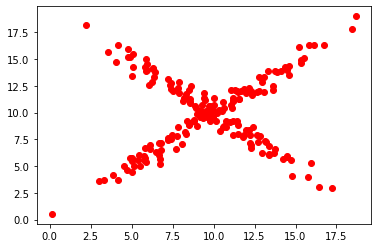

In [14]:
# Synthetic data
mu_act = np.array([10,10])
sigma_1 = np.array([[10,9.8],[9.8,10]])
sigma_2 = np.array([[10,-9.8],[-9.8,10]])

X1 = np.random.multivariate_normal(mu_act,sigma_1,100)
X2 = np.random.multivariate_normal(mu_act,sigma_2,100)

X = np.concatenate((X1,X2),0)

plt.plot(X[:,0],X[:,1],'ro')

**GMM Algorithm**

- Randomly/arbitrarily initialize $\phi_1, \ldots, \mu_1, \ldots, \Sigma_1, \ldots$
- Repeat until convergence:
  - E-step:
    - For $i \in 1..m$, $j \in 1..k$,
      $$w^{(i)}_j \leftarrow p(z^{(i)} \mid \mathbf{x}^{(i)} ; \phi_1, \ldots, \mu_1, \ldots, \Sigma_1, \ldots)$$
  - M-step:
    - Update $\phi_1, \ldots$: $$\phi_j \leftarrow \frac{1}{m} \sum_{i=1}^m w_j^{(i)}$$
    - Update $\mu_1, \ldots$: $$\mu_j \leftarrow \frac{\sum_i w_j^{(i)} \mathbf{x}^{(i)}}{\sum_i w_j^{(i)}}$$
    - Update $\Sigma_1, \ldots$: $$\Sigma_j \leftarrow \frac{\sum_i w_j^{(i)} (\mathbf{x}^{(i)}-\mu_j)(\mathbf{x}^{(i)}-\mu_j)^T}{\sum_i w_j^{(i)}}$$

In [118]:
k1 = 2
m1 = X.shape[0]
indices1 = np.random.choice(np.arange(m1),k1,replace=False)
mu1 = X[indices1,:]
data_cov1 = X.T@X/m1
sigma1 = []
for j in range(k1):
    sigma1.append(data_cov1.copy())
phi1 = np.ones(k1)/k1

In [64]:
mu1.shape

(2, 2)

In [65]:
data_cov1.shape,data_cov1

((2, 2),
 array([[106.05570885,  98.52686477],
        [ 98.52686477, 111.12516754]]))

In [66]:
type(sigma1),sigma1

(list,
 [array([[106.05570885,  98.52686477],
         [ 98.52686477, 111.12516754]]),
  array([[106.05570885,  98.52686477],
         [ 98.52686477, 111.12516754]])])

In [67]:
phi1.shape,phi1

((2,), array([0.5, 0.5]))

In [68]:
j = 1
sigma1[j].shape

(2, 2)

In [119]:
wold = np.zeros((k1,m1))
steps = []
costs = []
step = 0 
while True:
    step +=1
    steps.append(step)
    
    # E-step: Calculate weight for each point in each cluster p(z^i = j | x^i)
    w1 = np.zeros((k1,m1))
    for j in range(k1):
        w1[j,:] = scipy.stats.multivariate_normal.pdf(X,mean=mu1[j,:],cov=sigma1[j])*phi1[j] #Probability density function
    cost = -np.log(w1.sum(axis=0)).mean()
    costs.append(cost)
    w1 = w1/w1.sum(axis=0)
    
    # M-step: Update parameters
    phi1= w.mean(axis=1)
    for j in range(k1):
        mu1[j,:] = (w1[j,:].reshape(m1,1)*X).sum(axis=0)/w1[j,:].sum()
    
    for j in range(k1):
        sigma1[j] = ((w1[j:j+1,:].T*(X-mu1[j,:])).T@(X-mu1[j,:]))/w1[j,:].sum()
        
    # Check for convergence
    if (w1 - wold <= 1e-6).all():
        break
    wold = w1.copy()

In [131]:
type(sigma1)

list

Cost: 4.1663983849116395


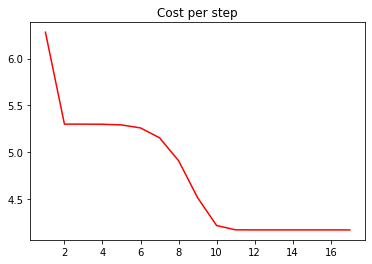

In [120]:
print('Cost:',costs[-1])

plt.plot(steps, costs,'r-')
plt.title('Cost per step')
plt.show()

**GMM Function**

In [189]:
def gmm(X,k):
    # Initialize parameters
    m = X.shape[0]
    indices = np.random.choice(np.arange(m),k,replace=False)
    mu = X[indices,:]
    data_cov = X.T@X/m
    sigma = []
    for i in range(k):
        sigma.append(data_cov.copy())
    phi = np.ones(k)/k
    
    # Repeat until convergence
    wold = np.zeros((k,m))
    while True:
        w = np.zeros((k,m))
        # E-step
        for j in range(k):
            w[j,:]=scipy.stats.multivariate_normal.pdf(X[:,:],mean=mu[j,:],cov=sigma[j])*phi[j]
        w = w/w.sum(axis=0)
        cost = -np.log(w.sum(axis=0)).mean()
        
        # M-step: Update the parameters
        phi = w.mean(axis=1)
        
        for j in range(k):
            mu[j,:] = (w[j,:].reshape(m,1)*X).sum(axis=0)/w[j,:].sum()
            
        for j in range(k):
            sigma[j] = (w[j:j+1,:].T*(X - mu[j,:])).T@(X - mu[j,:])/w[j,:].sum()
        
        # Check for convergence
        if (w - wold <= 1e-6).all():
            break
        
        wold = w.copy()
    return phi, mu, sigma

In [190]:
phi, mu, sigma =  gmm(X,2)

In [200]:
# predict function
def gmm_predict(X,phi,mu,sigma):
    m = X.shape[0]
    k = mu.shape[0]
    w = np.zeros((k,m))
    for i in range(m):
        for j in range(k):
            w[j,i]=scipy.stats.multivariate_normal.pdf(X[i,:],mean=mu[j,:],cov=sigma[j])*phi[j]
        results = np.argmax(w,axis=0)
    return results

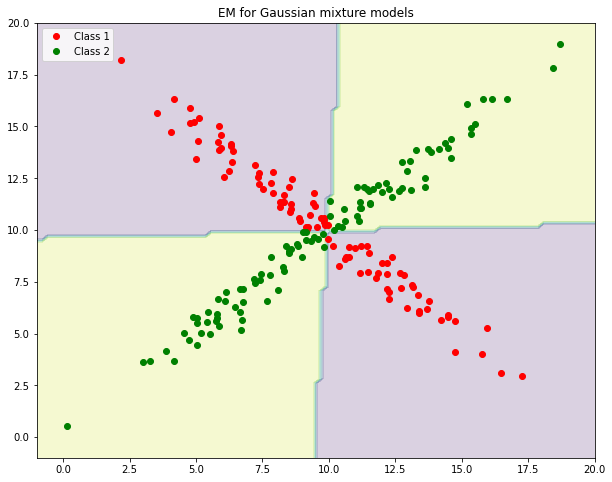

In [199]:
# Plot results
plt.figure(figsize = (10,8))

# Color points
indices = gmm_predict(X,phi,mu,sigma)
plt.plot(X[indices==0,0],X[indices==0,1],'ro',label='Class 1')
plt.plot(X[indices==1,0],X[indices==1,1],'go',label='Class 2')

# Color regions
grid_x,grid_y = np.mgrid[-1:20:100j,-1:20:100j]
grid_xy = np.vstack([grid_x.ravel(),grid_y.ravel()]).T
z = gmm_predict(grid_xy,phi,mu,sigma).reshape((100,100))
plt.contourf(grid_x,grid_y,z,alpha = 0.2)

plt.title('EM for Gaussian mixture models')
plt.legend()
plt.show()